### Made by Liang Yihuai

This notebook is for feature engineering and find out the important features.

In [1]:
#imports
import os
from os.path import join
import glob
import pandas as pd
import numpy as np
%load_ext autoreload
%autoreload 2

In [2]:
# load data
dataroot = 'dataset/MachineLearningCVE/'

In [3]:
def read_data(dataroot,file_ending):
    if file_ending==None:
        print("please specify file ending pattern for glob")
        exit()
    print(join(dataroot,file_ending))
    filenames = [i for i in glob.glob(join(dataroot,file_ending))]
    combined_csv = pd.concat([pd.read_csv(f, low_memory=False) for f in filenames],sort=False)
    return combined_csv

In [4]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [5]:
data = read_data(dataroot,'*.pcap_ISCX.csv')

dataset/MachineLearningCVE/*.pcap_ISCX.csv


C:\Users\media\Anaconda3\envs\fastai\lib\site-packages\IPython\core\interactiveshell.py:3326: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\media\Anaconda3\envs\fastai\lib\site-packages\IPython\core\interactiveshell.py:3326: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
num_records,num_features = data.shape
print("{} flow records read which has {} feature dimension".format(num_records,num_features))

2830743 flow records read which has 79 feature dimension


In [7]:
# there is white spaces in columns names e.g. ' Destination Port'
# So strip the whitespace from  column names
data = data.rename(columns=lambda x: x.strip())
df_label = data['Label']
data = data.drop(columns=['Flow Packets/s','Flow Bytes/s', 'Fwd Avg Bytes/Bulk',
                          'Fwd Avg Packets/Bulk','Fwd Avg Bulk Rate',
                          'Bwd Avg Bytes/Bulk','Bwd Avg Packets/Bulk','Bwd Avg Bulk Rate','Label'])
data.fillna(data.mean(), inplace=True)

In [8]:
data = data.astype(float).apply(pd.to_numeric)

In [9]:
# lets count if there is NaN values in our dataframe( AKA missing features)
data.isnull().sum().sum()

0

In [10]:
#Since the above data is imbalanced we do oversampling to balance data
def balance_data(X,y):
    unique,counts = np.unique(y,return_counts=True)
    mean_samples_per_class = int(round(np.mean(counts)))
    new_X = np.empty((0,X.shape[1]))
    new_y = np.empty((0),dtype=int)
    for i,c in enumerate(unique):
        temp_x = X[y==c]
        indices = np.random.choice(temp_x.shape[0],mean_samples_per_class)
        new_X = np.concatenate((new_X,temp_x[indices]),axis=0)
        temp_y = np.ones(mean_samples_per_class,dtype=int)*c
        new_y = np.concatenate((new_y,temp_y),axis=0)

    # in order to break class order in data we need shuffling
    indices = np.arange(new_y.shape[0])
    np.random.shuffle(indices)
    new_X =  new_X[indices,:]
    new_y = new_y[indices]
    return (new_X,new_y)


In [11]:
# chganges label from string to integer/index
def encode_label(Y_str):
    labels_d = make_value2index(np.unique(Y_str))
    Y = [labels_d[y_str] for y_str  in Y_str]
    Y = np.array(Y)
    return np.array(Y)

def make_value2index(attacks):
    #make dictionary
    attacks = sorted(attacks)
    d = {}
    counter=0
    for attack in attacks:
        d[attack] = counter
        counter+=1
    return d


In [12]:
# normalization
def normilize(data):
        data = data.astype(np.float32)
       
        eps = 1e-15

        mask = data==-1
        data[mask]=0
        mean_i = np.mean(data,axis=0)
        min_i = np.min(data,axis=0) #  to leave -1 (missing features) values as is and exclude in normilizing
        max_i = np.max(data,axis=0)

        r = max_i-min_i+eps
        data = (data-mean_i)/r  # zero centered 

        #deal with missing features -1
        data[mask] = 0
        
        nan_index = np.isnan(data)
        nan_data = data[nan_index]
        
        return data

In [13]:
from sklearn import preprocessing
data_np = data.values # convert to numpy array
X = data_np
X = normilize(X)
#X = preprocessing.scale(X)
y = df_label.values
y = encode_label(y)
N = X.shape[0]
print(X.shape,y.shape)

(2830743, 70) (2830743,)


In [39]:
index_to_labels = sorted(np.unique(df_label.values))

In [40]:
index_to_labels

['BENIGN',
 'Bot',
 'DDoS',
 'DoS GoldenEye',
 'DoS Hulk',
 'DoS Slowhttptest',
 'DoS slowloris',
 'FTP-Patator',
 'Heartbleed',
 'Infiltration',
 'PortScan',
 'SSH-Patator',
 'Web Attack � Brute Force',
 'Web Attack � Sql Injection',
 'Web Attack � XSS']

In [43]:
display_all(data.describe().T)

,count,mean,std,min,25%,50%,75%,max
Destination Port,2830743.0,8.071483e+03,1.828363e+04,0.000000e+00,53.000000,80.000000,4.430000e+02,6.553500e+04
Flow Duration,2830743.0,1.478566e+07,3.365374e+07,-1.300000e+01,155.000000,31316.000000,3.204828e+06,1.200000e+08
Total Fwd Packets,2830743.0,9.361160e+00,7.496728e+02,1.000000e+00,2.000000,2.000000,5.000000e+00,2.197590e+05
Total Backward Packets,2830743.0,1.039377e+01,9.973883e+02,0.000000e+00,1.000000,2.000000,4.000000e+00,2.919220e+05
Total Length of Fwd Packets,2830743.0,5.493024e+02,9.993589e+03,0.000000e+00,12.000000,62.000000,1.870000e+02,1.290000e+07
Total Length of Bwd Packets,2830743.0,1.616264e+04,2.263088e+06,0.000000e+00,0.000000,123.000000,4.820000e+02,6.554530e+08
Fwd Packet Length Max,2830743.0,2.075999e+02,7.171848e+02,0.000000e+00,6.000000,37.000000,8.100000e+01,2.482000e+04
Fwd Packet Length Min,2830743.0,1.871366e+01,6.033935e+01,0.000000e+00,0.000000,2.000000,3.600000e+01,2.325000e+03
Fwd Packet Length Mean,2830743.0,5.820194e+01,1.860912e+02,0.000000e+00,6.000000,34.000000,5.000000e+01,5.940857e+03
Fwd Packet Length Std,2830743.0,6.891013e+01,2.811871e+02,0.000000e+00,0.000000,0.000000,2.616295e+01,7.125597e+03


In [45]:
for i, v in enumerate(data.columns):
    print(i, v)

0 Destination Port
1 Flow Duration
2 Total Fwd Packets
3 Total Backward Packets
4 Total Length of Fwd Packets
5 Total Length of Bwd Packets
6 Fwd Packet Length Max
7 Fwd Packet Length Min
8 Fwd Packet Length Mean
9 Fwd Packet Length Std
10 Bwd Packet Length Max
11 Bwd Packet Length Min
12 Bwd Packet Length Mean
13 Bwd Packet Length Std
14 Flow IAT Mean
15 Flow IAT Std
16 Flow IAT Max
17 Flow IAT Min
18 Fwd IAT Total
19 Fwd IAT Mean
20 Fwd IAT Std
21 Fwd IAT Max
22 Fwd IAT Min
23 Bwd IAT Total
24 Bwd IAT Mean
25 Bwd IAT Std
26 Bwd IAT Max
27 Bwd IAT Min
28 Fwd PSH Flags
29 Bwd PSH Flags
30 Fwd URG Flags
31 Bwd URG Flags
32 Fwd Header Length
33 Bwd Header Length
34 Fwd Packets/s
35 Bwd Packets/s
36 Min Packet Length
37 Max Packet Length
38 Packet Length Mean
39 Packet Length Std
40 Packet Length Variance
41 FIN Flag Count
42 SYN Flag Count
43 RST Flag Count
44 PSH Flag Count
45 ACK Flag Count
46 URG Flag Count
47 CWE Flag Count
48 ECE Flag Count
49 Down/Up Ratio
50 Average Packet Size
51

In [14]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_final_test, y_train, y__final_test = train_test_split(
    X, y, test_size=0.2, random_state=2)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=2)

In [15]:
unique,counts = np.unique(y_train,return_counts=True)
print(unique, counts)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] [1636805    1402   92068    7398  166350    3951    4162    5821       5
      27  114386    4188    1085      13     473]


In [16]:
np.random.seed(5)
X_train_balanced,y_train_balanced = balance_data(X_train,y_train)
print(X_train_balanced.shape, y_train_balanced.shape, data.shape)

unique,counts = np.unique(y_train_balanced,return_counts=True)
print(unique, counts)

(2038140, 70) (2038140,) (2830743, 70)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] [135876 135876 135876 135876 135876 135876 135876 135876 135876 135876
 135876 135876 135876 135876 135876]


In [17]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250, random_state=0)

forest.fit(X_train, y_train)


In [47]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 44 (0.063457)
2. feature 0 (0.048694)
3. feature 58 (0.039773)
4. feature 11 (0.038625)
5. feature 52 (0.037491)
6. feature 39 (0.034387)
7. feature 12 (0.032973)
8. feature 13 (0.032285)
9. feature 50 (0.030899)
10. feature 69 (0.028542)
11. feature 45 (0.028469)
12. feature 16 (0.028291)
13. feature 38 (0.028285)
14. feature 21 (0.028053)
15. feature 10 (0.028044)
16. feature 40 (0.023179)
17. feature 66 (0.022569)
18. feature 68 (0.022087)
19. feature 34 (0.021765)
20. feature 20 (0.021725)
21. feature 36 (0.021045)
22. feature 1 (0.016080)
23. feature 18 (0.015479)
24. feature 37 (0.015417)
25. feature 60 (0.014763)
26. feature 15 (0.014375)
27. feature 2 (0.014016)
28. feature 49 (0.013642)
29. feature 7 (0.013367)
30. feature 9 (0.012836)
31. feature 54 (0.012382)
32. feature 51 (0.012378)
33. feature 55 (0.011972)
34. feature 59 (0.011448)
35. feature 14 (0.011178)
36. feature 19 (0.011036)
37. feature 46 (0.010926)
38. feature 8 (0.010558)
39. featur

In [20]:
from matplotlib import pyplot as plt 

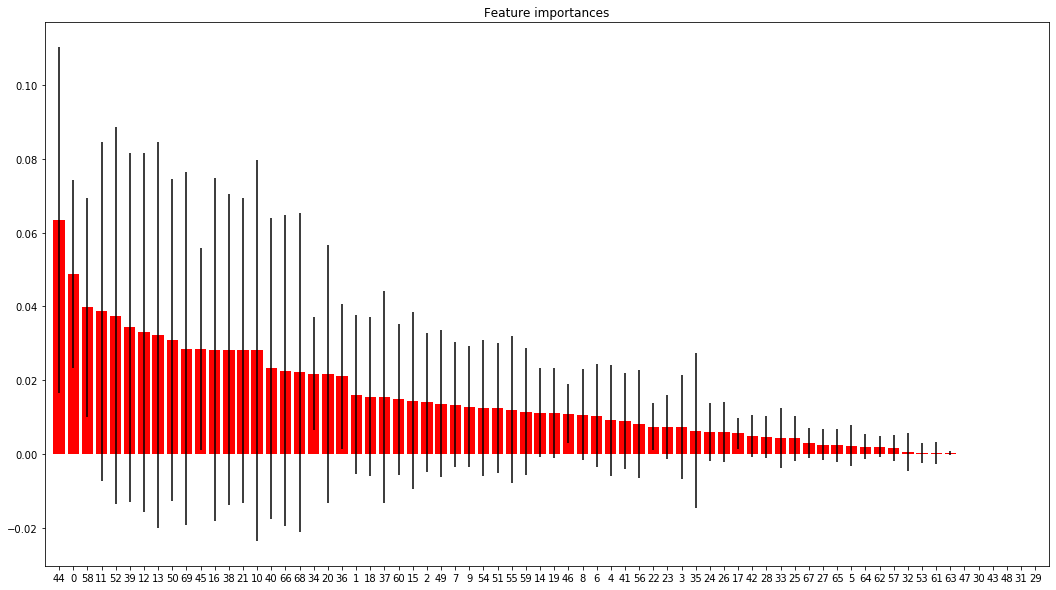

In [30]:
# Plot the feature importances of the forest
plt.figure(figsize=(18, 10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

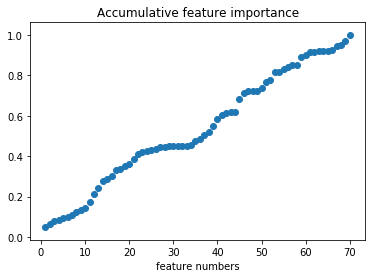

In [49]:
accumulations = []
accumulator = 0.0
for v in importances:
    accumulator += v
    accumulations.append(accumulator)

plt.title('Accumulative feature importance')
plt.xlabel('feature numbers')
plt.scatter(range(1, len(accumulations)+1), accumulations)
plt.show()

only keep 64 features

In [51]:
accumulator = 0.0
for i in range(64):
    accumulator += importances[i]

print(accumulator)

0.9196366008895135


Remove unimportant features, only keep 64 features. I print out those unimportant features

In [52]:
indexs = [47, 30, 43, 48, 31, 29]

features_remove = []
for v in indexs:
    features_remove.append(data.columns[v])
    
features_remove

['CWE Flag Count',
 'Fwd URG Flags',
 'RST Flag Count',
 'ECE Flag Count',
 'Bwd URG Flags',
 'Bwd PSH Flags']